In [ ]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
%matplotlib inline 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

trainLabels = pd.read_csv("/content/drive/My Drive/trainLabels.csv")
trainLabels

image  level
0          10_left      0
1         10_right      0
2          13_left      0
3         13_right      0
4          15_left      1
...            ...    ...
35121  44347_right      0
35122   44348_left      0
35123  44348_right      0
35124   44349_left      0
35125  44349_right      1

[35126 rows x 2 columns]

In [ ]:
len(trainLabels)

35126

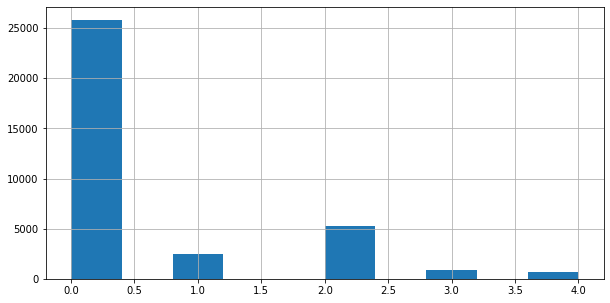

In [ ]:
trainLabels['level'].hist(figsize = (10, 5))

In [ ]:
from PIL import Image
from keras.preprocessing import image

In [ ]:
retina_data=trainLabels


In [ ]:
base_image_dir=os.path.join('/content/drive/My Drive/new_train_data')


In [ ]:
trainLabels['path'] = retina_data['image'].map(lambda x: os.path.join(base_image_dir,
                                                       '{}.jpeg'.format(x)))
retina_data['exists'] = retina_data['path'].map(os.path.exists)

In [ ]:
print(retina_data['exists'].sum(), 'images found of', retina_data.shape[0], 'total')

1748 images found of 35126 total


In [ ]:
retina_data.to_csv (r'C:\Users\soumy\Desktop\converted_df.csv', index = None, header=True)

In [ ]:
retina_data['eye'] = retina_data['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)
from keras.utils.np_utils import to_categorical
retina_data['level_cat'] = retina_data['level'].map(lambda x: to_categorical(x, 1+retina_data['level'].max()))

retina_data.dropna(inplace = True)
retina_data = retina_data[retina_data['exists']]


In [ ]:
retina_data2=retina_data[retina_data['level']==0]
retina_data2=retina_data2[1:1000]

In [ ]:
retina_data=retina_data[retina_data['level'].isin([3,4])]

In [ ]:
len(retina_data)

In [ ]:
retina_data.loc[retina_data['level'] ==3, 'level'] = 1
retina_data.loc[retina_data['level'] ==4, 'level'] = 1

In [ ]:
retina_data = pd.concat([retina_data2, retina_data], axis=0)


In [ ]:
retina_data['level_cat'] = retina_data['level'].map(lambda x: to_categorical(x, 1+retina_data['level'].max()))

In [ ]:
retina_data

image  ...  exists
1         10_right  ...    True
2          13_left  ...    True
3         13_right  ...    True
8          17_left  ...    True
10         19_left  ...    True
...            ...  ...     ...
22978   29027_left  ...    True
22979  29027_right  ...    True
23013  29058_right  ...    True
23034   29097_left  ...    True
23035  29097_right  ...    True

[1747 rows x 6 columns]

In [ ]:
from keras.preprocessing import image
from PIL import ImageEnhance

In [ ]:


from PIL import Image
import pandas as pd
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
immatrix2 = []
imlabel = []
img=[]
img_rows, img_cols = 256,256
listing=retina_data['path']
for file in listing:
    im = Image.open(file)
    im = ImageEnhance.Brightness(im).enhance(1.7)
    enhancer_object = ImageEnhance.Contrast(im)
    im = enhancer_object.enhance(1.7)
    enhancer_object = ImageEnhance.Sharpness(im)
    im= enhancer_object.enhance(2.7)
    img = np.array(im.resize((img_rows,img_cols)))
     # convert to green channel only
    #img[:,:,[0,2]] = 0
    immatrix2.append(img)
    

In [ ]:
np.save('/content/drive/My Drive/nparray',immatrix2)

In [ ]:
immatrix2=np.load('/content/drive/My Drive/nparray.npy')

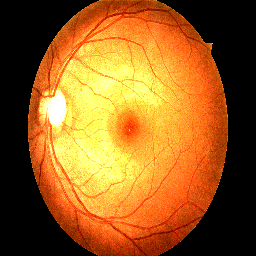

In [ ]:

im = Image.fromarray(immatrix2[1],'RGB')
im

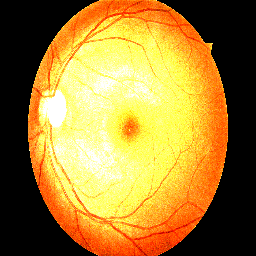

In [ ]:
im = ImageEnhance.Brightness(im).enhance(1.7)
im


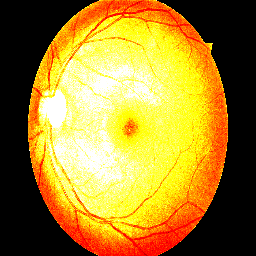

In [ ]:
enhancer_object = ImageEnhance.Contrast(im)
im = enhancer_object.enhance(1.7)
im

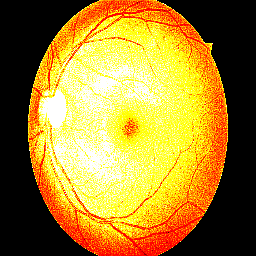

In [ ]:
enhancer_object = ImageEnhance.Sharpness(im)
im= enhancer_object.enhance(3)
im

In [ ]:
Label=retina_data['level']

In [ ]:
from sklearn.utils import shuffle

data,label = shuffle(immatrix2, Label, random_state=42)
train_data = [data,label]
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_data[0], train_data[1], test_size = 0.2, random_state = 42)

print(np.array(x_train).shape)
print(np.array(y_train).shape)

(1397, 256, 256, 3)
(1397,)


In [ ]:
y_test1=y_test

In [ ]:
x_train = np.array(x_train).astype("float32")/255.
x_test = np.array(x_test).astype("float32")/255.

In [ ]:
from keras.utils import np_utils

y_train = np_utils.to_categorical(np.array(y_train), 2)
y_test = np_utils.to_categorical(np.array(y_test),2)


In [ ]:
y_train.shape

(1397, 2)

In [ ]:
from math import ceil
n_points=len(x_train)
steps_per_epoch = ceil(n_points/32)

**RESNET**

In [ ]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os
from math import ceil
# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 10  #200 original
data_augmentation = False
num_classes = 2

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True
n = 3

version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

In [ ]:

def lr_schedule(epoch):

    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


In [ ]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):

    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [ ]:
def resnet_v1(input_shape, depth, num_classes=2):
   
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6) #20-2,subtracting ip and op layers

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(2,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
model = resnet_v1(input_shape=x_train[0].shape, depth=20)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])

model.summary()
print(model_type)



Learning rate:  0.001
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_281 (Conv2D)             (None, 256, 256, 16) 448         input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_281[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 16) 0           batch_normalization_1[0][0]      
____________________________________________________________________

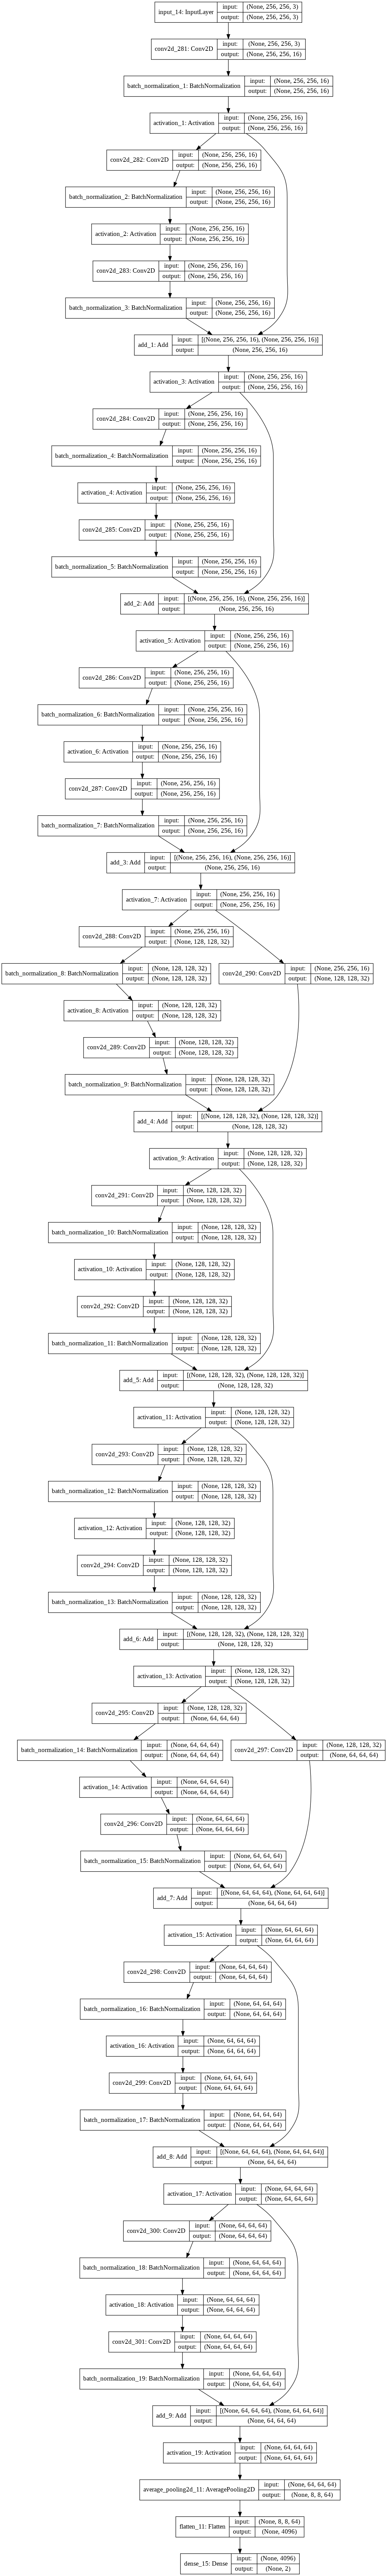

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='/content/drive/My Drive/model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=30,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history=model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=30, verbose=1, workers=4,
                        callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Not using data augmentation.
Train on 1397 samples, validate on 350 samples
Epoch 1/30
Learning rate:  0.001
1397/1397 [==============================] - 42s 30ms/step - loss: 0.6325 - acc: 0.7738 - val_loss: 0.8615 - val_acc: 0.6143

Epoch 00001: val_acc improved from -inf to 0.61429, saving model to /content/saved_models/cifar10_ResNet20v1_model.001.h5
Epoch 2/30
Learning rate:  0.001
1397/1397 [==============================] - 42s 30ms/step - loss: 0.6051 - acc: 0.7824 - val_loss: 0.9740 - val_acc: 0.6000

Epoch 00002: val_acc did not improve from 0.61429
Epoch 3/30
Learning rate:  0.001
1397/1397 [==============================] - 42s 30ms/step - loss: 0.6416 - acc: 0.7602 - val_loss: 0.9436 - val_acc: 0.5829

Epoch 00003: val_acc did not improve from 0.61429
Epoch 4/30
Learning rate:  0.001
1397/1397 [==============================] - 42s 30ms/step - loss: 0.5965 - acc: 0.7967 - val_loss: 1.0806 - val_acc: 0.5743

Epoch 00004: val_acc did not improve from 0.61429
Epoch 5/30
Learn

In [ ]:
ypred=model.predict(x_test, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)

In [ ]:
y_pred2=[]
for i in ypred:
    y_pred2.append(i.argmax())
y_pred2=np.asarray(y_pred2)

In [ ]:
confusion_matrix(y_test1, y_pred2)

array([[127,  79],
       [ 58,  86]])

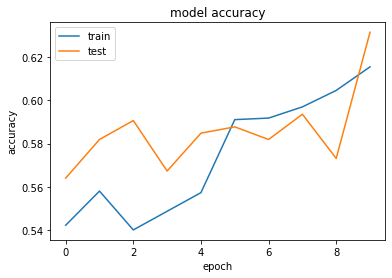

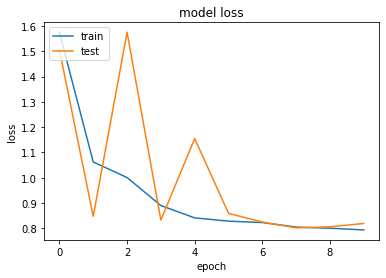

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)

100/100 [==============================] - 20s 203ms/step


In [ ]:
import glob, shutil
lists=retina_data['path']
for key, file in lists.iteritems():
    shutil.move(file, 'C:/Users/soumy/Desktop/DeepLearning/Diabetic_data/new_train_data/')

In [ ]:
import numpy as np
import os
import time
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
b_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
#freeze_layers(base_model)
b_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [ ]:
for layer in b_model.layers[:-3]:
    layer.trainable = False
# Check the trainable status of the individual layers
for layer in b_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fd47c00f550> False
<keras.layers.convolutional.Conv2D object at 0x7fd47bfc1978> False
<keras.layers.convolutional.Conv2D object at 0x7fd47bfc1b70> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd47bfca438> False
<keras.layers.convolutional.Conv2D object at 0x7fd47bf567f0> False
<keras.layers.convolutional.Conv2D object at 0x7fd47bf56e48> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd47bf63438> False
<keras.layers.convolutional.Conv2D object at 0x7fd47bf68da0> False
<keras.layers.convolutional.Conv2D object at 0x7fd47bf6f630> False
<keras.layers.convolutional.Conv2D object at 0x7fd47bf76518> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd47bf77d68> False
<keras.layers.convolutional.Conv2D object at 0x7fd47bf8acc0> False
<keras.layers.convolutional.Conv2D object at 0x7fd47bf90550> False
<keras.layers.convolutional.Conv2D object at 0x7fd47bf15550> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd47bf16c88>

In [ ]:
batch_size = 32
# number of output classes
nb_classes = 2
# number of epochs to train
nb_epoch = 10

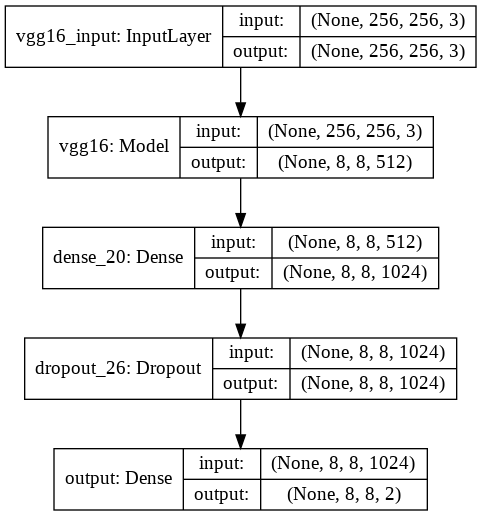

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model2, to_file='/content/drive/My Drive/model_plot3.png', show_shapes=True, show_layer_names=True)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# create generators  - training data will be augmented images
validationdatagenerator = ImageDataGenerator()
traindatagenerator = ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1,rotation_range=15,zoom_range=0.1 )

batchsize=8
train_generator=traindatagenerator.flow(x_train, y_train, batch_size=batchsize) 
validation_generator=validationdatagenerator.flow(x_test, y_test,batch_size=batchsize)

In [ ]:

from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model2 = models.Sequential()
 
# Add the vgg convolutional base model
model2.add(b_model)
 
# Add new layers
model2.add(layers.Dense(1024, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(nb_classes, activation='softmax', name ='output'))
 
# Show a summary of the model. Check the number of trainable parameters
model2.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
dense_20 (Dense)             (None, 8, 8, 1024)        525312    
_________________________________________________________________
dropout_26 (Dropout)         (None, 8, 8, 1024)        0         
_________________________________________________________________
output (Dense)               (None, 8, 8, 2)           2050      
Total params: 15,242,050
Trainable params: 5,246,978
Non-trainable params: 9,995,072
_________________________________________________________________


In [ ]:
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
history= model.fit_generator(train_generator, steps_per_epoch=int(len(x_train)/batchsize), 
                    epochs=10, validation_data=validation_generator, 
                    validation_steps=int(len(x_test)/batchsize))


Epoch 1/10
174/174 [==============================] - 62s 359ms/step - loss: 1.5750 - acc: 0.5422 - val_loss: 1.5055 - val_acc: 0.5640
Epoch 2/10
174/174 [==============================] - 51s 296ms/step - loss: 1.0617 - acc: 0.5585 - val_loss: 0.8473 - val_acc: 0.5819
Epoch 3/10
174/174 [==============================] - 51s 295ms/step - loss: 1.0005 - acc: 0.5401 - val_loss: 1.5755 - val_acc: 0.5906
Epoch 4/10
174/174 [==============================] - 51s 294ms/step - loss: 0.8912 - acc: 0.5483 - val_loss: 0.8324 - val_acc: 0.5673
Epoch 5/10
174/174 [==============================] - 51s 293ms/step - loss: 0.8417 - acc: 0.5565 - val_loss: 1.1551 - val_acc: 0.5848
Epoch 6/10
174/174 [==============================] - 51s 294ms/step - loss: 0.8281 - acc: 0.5915 - val_loss: 0.8591 - val_acc: 0.5877
Epoch 7/10
174/174 [==============================] - 51s 293ms/step - loss: 0.8231 - acc: 0.5910 - val_loss: 0.8248 - val_acc: 0.5819
Epoch 8/10
174/174 [==============================] - 5

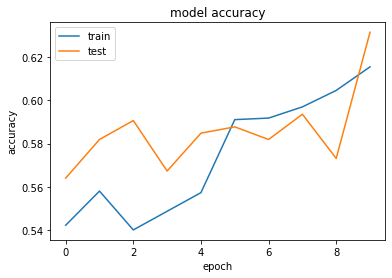

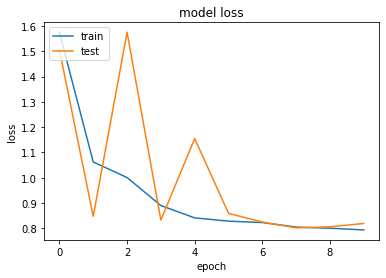

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [ ]:
ypred=model.predict(x_test, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)

In [ ]:

y_pred2=[]
for i in ypred:
    y_pred2.append(i.argmax())
y_pred2=np.asarray(y_pred2)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred2)

array([[173,  33],
       [ 93,  51]])

In [ ]:
def build_model(nb_classes):
    base_model = InceptionV3(weights='imagenet', include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer
    predictions = Dense(nb_classes, activation='softmax')(x)

    # this is the model we will train
    model = Model(input=base_model.input, output=predictions)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

    # compile the model (should be done *after* setting layers to non-trainable)
  
    return model 

In [ ]:
incmodel= build_model(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  del sys.path[0]


In [ ]:
import tensorflow as tf
from keras import backend as K
from keras.applications.inception_v3 import preprocess_input
import numpy as np

In [ ]:
import tensorflow as tf
from keras import backend as K
from keras.applications.inception_v3 import preprocess_input
import numpy as np

In [ ]:
# Keras and TensorFlow must be (pip) installed.
from keras.applications import InceptionV3
from keras.models       import Model

In [ ]:
original_model    = InceptionV3()
bottleneck_input  = original_model.get_layer(index=0).input
bottleneck_output = original_model.get_layer(index=-2).output
bottleneck_model  = Model(inputs=bottleneck_input, outputs=bottleneck_output)

In [ ]:
plot_model(bottleneck_model, to_file='/content/drive/My Drive/model_plot5.png', show_shapes=True, show_layer_names=True)

In [ ]:
Model(inputs=bottleneck_input, outputs=bottleneck_output)

In [ ]:
for layer in bottleneck_model.layers:
    layer.trainable = False

In [ ]:
from keras.models import Sequential
new_model = Sequential()
new_model.add(bottleneck_model)
new_model.add(Dense(2, activation='softmax', input_dim=2048))

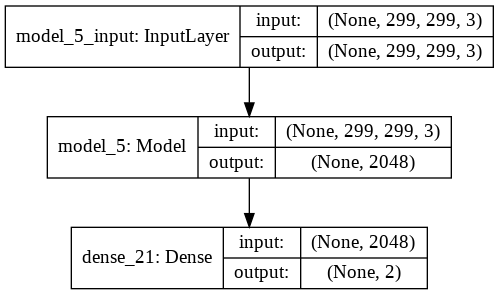

In [ ]:
plot_model(new_model, to_file='/content/drive/My Drive/model_plot4.png', show_shapes=True, show_layer_names=True)

In [ ]:
# For a binary classification problem
new_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

new_model.fit(
              x_train, y_train,
              epochs=10, 
              batch_size=32)

Epoch 1/10
1397/1397 [==============================] - 29s 20ms/step - loss: 0.5276 - acc: 0.7459
Epoch 2/10
1397/1397 [==============================] - 14s 10ms/step - loss: 0.4825 - acc: 0.7659
Epoch 3/10
1397/1397 [==============================] - 14s 10ms/step - loss: 0.4969 - acc: 0.7566
Epoch 4/10
1397/1397 [==============================] - 14s 10ms/step - loss: 0.4645 - acc: 0.7702
Epoch 5/10
1397/1397 [==============================] - 14s 10ms/step - loss: 0.4679 - acc: 0.7781
Epoch 6/10
1397/1397 [==============================] - 14s 10ms/step - loss: 0.4480 - acc: 0.7931
Epoch 7/10
1397/1397 [==============================] - 14s 10ms/step - loss: 0.4501 - acc: 0.7845
Epoch 8/10
1397/1397 [==============================] - 14s 10ms/step - loss: 0.4633 - acc: 0.7895
Epoch 9/10
1397/1397 [==============================] - 14s 10ms/step - loss: 0.4334 - acc: 0.8039
Epoch 10/10
1397/1397 [==============================] - 14s 10ms/step - loss: 0.4473 - acc: 0.7860


In [ ]:
ypred=incmodel.predict(x_test, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)

In [ ]:
y_pred2=[]
for i in ypred:
    y_pred2.append(i.argmax())
y_pred2=np.asarray(y_pred2)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test1, y_pred2)

array([[206,   0],
       [144,   0]])

In [ ]:
import keras
from keras.layers.core import Layer
import keras.backend as K
import tensorflow as tf

In [ ]:
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten

import cv2 
import numpy as np 
from keras.datasets import cifar10 
from keras import backend as K 
from keras.utils import np_utils

import math 
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler

In [ ]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [ ]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [ ]:
input_layer = Input(shape=(256, 256, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.4)(x1)
x1 = Dense(2, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.4)(x2)
x2 = Dense(2, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(2, activation='softmax', name='output')(x)

In [ ]:
model = Model(input_layer, [x, x1, x2], name='inception_v1')

In [ ]:
plot_model(model, to_file='/content/drive/My Drive/model_plot2.png', show_shapes=True, show_layer_names=True)

In [ ]:
epochs = 10
initial_lrate = 0.01

def decay(epoch, steps=32):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)

model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], loss_weights=[1, 0.3, 0.3], optimizer=sgd, metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, [y_train, y_train, y_train], validation_data=(x_test, [y_test, y_test, y_test]), epochs=epochs, batch_size=32, callbacks=[lr_sc])

Train on 1397 samples, validate on 350 samples
Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
1397/1397 [==============================] - 27s 20ms/step - loss: 1.2460 - output_loss: 0.8212 - auxilliary_output_1_loss: 0.7060 - auxilliary_output_2_loss: 0.7101 - output_acc: 0.5397 - auxilliary_output_1_acc: 0.5290 - auxilliary_output_2_acc: 0.5268 - val_loss: 1.1129 - val_output_loss: 0.7033 - val_auxilliary_output_1_loss: 0.6852 - val_auxilliary_output_2_loss: 0.6801 - val_output_acc: 0.4114 - val_auxilliary_output_1_acc: 0.5886 - val_auxilliary_output_2_acc: 0.5886
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.01.
1397/1397 [==============================] - 17s 12ms/step - loss: 1.1472 - output_loss: 0.7315 - auxilliary_output_1_loss: 0.6932 - auxilliary_output_2_loss: 0.6923 - output_acc: 0.5032 - auxilliary_output_1_acc: 0.5526 - auxilliary_output_2_acc: 0.5576 - val_loss: 1.2010 - val_output_loss: 0.7855 - val_auxilliary_o

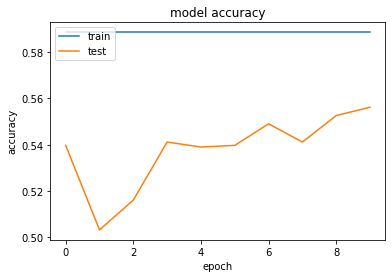

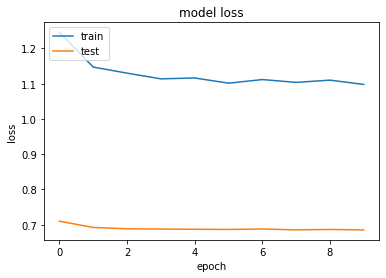

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['val_auxilliary_output_2_acc'])
plt.plot(history.history['output_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['auxilliary_output_2_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')